# Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Lunar Lander environment

In [2]:
seed = 543
def fix(env, seed):
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
import gymnasium as gym
import random
env = gym.make('LunarLander-v2' ,render_mode='rgb_array')
fix(env, seed) # fix the environment Do not revise this !!!

In [ ]:
env.reset()

# PPO Agent

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
N = 3

cuda


## Class: Memory

store the actions, states, rewards, is_termminal, and log probabilities

In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

## Class: ActorCritic

### 2 fully connected networks
1. actor/action layer: input the states, follow the policy and yields an action
2. critic/value layer: input the states, evaluate the current estimated rewards

### act function

Generate a probability distribution of the actions using action layer taking state as the input, sample one action and store these information in the memory.

### evaluate function

Take a state as input and generate action probability distribution, calculate the entropy of this distribution and evaluate the log probability of the given action. Use the critic to evaluate the expected rewards under current state. Return all these values.

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, n_latent_var),
                nn.ReLU(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )

        # critic
        self.value_layer = nn.Sequential(
               nn.Linear(state_dim, 128),
               nn.ReLU(),
               nn.Linear(128, n_latent_var),
               nn.ReLU(),
               nn.Linear(n_latent_var, 1)
               )
    
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

## PPO agent

### gamma

if close to 1, future rewards will be considered more
if close to 0, current rewards wiil take more proportion

### state_values

the output of the critic, which evaluates the state and give an expected future reward

### rewards

the static list of discounted rewards calculated by the data in old trajectory (when adopting old policy)

### advantages = rewards - state_values.detach()

how better the old policy perform than current policy. if positive, actual reward is higher than state value, it is better to stick to current action, vice versa

In [6]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, n_latent_var,update_timestep, lr, betas, gamma, K_epochs, eps_clip, c1, c2):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.update_timestep = update_timestep
        self.timestep = 0
        self.memory = Memory()

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()
        self.update_cnt = 0

        self.c1 = c1
        self.c2 = c2


    def update(self):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.stack(self.memory.states).detach().to(device)
        old_actions = torch.stack(self.memory.actions).detach().to(device)
        old_logprobs = torch.stack(self.memory.logprobs).detach().to(device)

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values 
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss 
            advantages = rewards - state_values.detach()
            
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages # clip to avoid large difference between samples
            loss = -torch.min(surr1, surr2)  + self.c1*self.MseLoss(state_values, rewards) + self.c2*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear_memory()

    def step(self, reward, done):
        self.timestep += 1 
        # Saving reward and is_terminal:
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)

        # update the policy per "update_timestep"
        if self.timestep % self.update_timestep == 0:
            self.update()
            self.memory.clear_memory()
            self.timestep = 0
            self.update_cnt += 1

    def act(self, state):
        return self.policy_old.act(state, self.memory)
    
    def train(self):
        self.policy.train()
        self.policy_old.train()

    def eval(self):
        self.policy.eval()
        self.policy_old.eval()

## Helping functions

In [7]:
def moving_average(total_rewards):
    if len(total_rewards) == 0:
        return 0
    if len(total_rewards) < 99:
        return np.mean(total_rewards)
    else:
        return np.mean(total_rewards[-100:])
    
def reward_shaping(pre_state, state, type):
    if (type == "center"):
        pre_shaping = -20*np.abs(pre_state[0])
        shaping = -20*np.abs(state[0])
    if (type == "horizontal"):
        pre_shaping = -1*np.abs(pre_state[4])
        shaping = -1*np.abs(state[4])
    if (type == "both"):
        pre_shaping = -10*np.abs(pre_state[0])-5*abs(pre_state[4])
        shaping = -10*np.abs(state[0])-5*abs(state[4])
    if (type == "none"):
        pre_shaping, shaping = 0, 0
    return shaping - pre_shaping

## Training function

In [8]:
def TrainOnce(c2, eps_clip, agent, reward_mode = "none", target_score = 200, target_success_rate = 0.9, max_episodes=2000, max_steps=900):
    agent.train()
    print(f"Training with c2: {c2}, eps_clip: {eps_clip}")
    total_rewards = []
    final_rewards = []
    moving_average_rewards = []
    num_episodes = 0
    success_rate = 0
    while True:
        num_episodes += 1
        state = env.reset()[0]
        total_reward = 0
        total_shaped_reward = 0
        step = 0
        # update_cnt = agent.update_cnt
        while True:
            step +=1
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            shaped_reward = reward + reward_shaping(state, next_state, reward_mode)
            total_shaped_reward += shaped_reward # use the shaped reward to train
            agent.step(shaped_reward, done)
            
            state = next_state
            if done or step >= max_steps:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

        moving_average_rewards.append(moving_average(total_rewards))
        success_rate = final_rewards[-300:].count(100) / 300

        if (num_episodes % 100 == 0):
            print(f"Update Count: {agent.update_cnt}, average rewards: {moving_average_rewards[-1]}, episode: {num_episodes}, success rate: {success_rate}")
        
        # finish the training if any one condition is reached
        if (moving_average(total_rewards) >= target_score):
            print(f"Target score reached in {num_episodes} episodes!")
            break
        if (success_rate >= target_success_rate):
            print(f"Target success rate reached in {num_episodes} episodes!")
            break
        if (num_episodes >= max_episodes):
            print(f"Max episodes {max_episodes} reached!")
            break

    training_result = {
        "total_rewards": total_rewards,
        "moving_average_rewards": moving_average_rewards,
        "final_rewards": final_rewards,
        "num_episodes": num_episodes,
        "success_rate": success_rate
    }
    return training_result

## Evaluation function

In [9]:
def EvaluateOnce(agent, eval_num = 500):
    agent.eval()
    test_total_rewards = []
    test_final_rewards = []
    success_rate = 0
    prg_bar = tqdm(range(eval_num))
    for i in prg_bar:
        state = env.reset()[0]
        total_reward = 0
        step = 0
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            step += 1
            if (step>3000):
                done = True
        test_total_rewards.append(total_reward)
        test_final_rewards.append(reward)
    success_rate = test_final_rewards.count(100) / eval_num
    print(f"Test success rate {success_rate} over {eval_num} games")
    eval_result = {
        "test_total_rewards": test_total_rewards,
        "test_final_rewards": test_final_rewards,
        "success_rate": success_rate
    }
    return eval_result

# Bayesian Optimization

## Use BayesianOptimization to find the best pair of c2 and eps_clip

In [10]:
from bayes_opt import BayesianOptimization
state_dim = 8 
action_dim = 4 
n_latent_var = 64
update_timestep = 1000
c1 = 0.5
lr = 0.003
betas = (0.9, 0.999)
gamma = 0.99
K_epochs = 4

if (False):
    p_bounds = {'c2': (-0.01, -0.005), 'eps_clip': (0.1,0.3)}

    def PPO_fn(c2, eps_clip):
        agent = PPOAgent(state_dim,action_dim,n_latent_var,update_timestep,lr,betas,gamma,K_epochs,eps_clip,c1,c2)
        training_result = TrainOnce(c2, eps_clip, agent, target_score=200)
        return -training_result["num_episodes"]
    HyperParamOptimizer = BayesianOptimization(
        f=PPO_fn,
        pbounds=p_bounds,
        random_state=1
    )
    HyperParamOptimizer.probe(
        params=[-0.006, 0.22],
        lazy=True
    )
    HyperParamOptimizer.maximize(
        init_points=2,
        n_iter=7
    )
    print(HyperParamOptimizer.max)
    c2 = HyperParamOptimizer.max['params']['c2']
    eps_clip = HyperParamOptimizer.max['params']['eps_clip']
else:
    c2=-0.006
    eps_clip=0.22

# Train a excellent model

## Keep training until landing success rate over previous 300 episodes reaches 95%

In [11]:
agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
excellent_result = TrainOnce(c2, eps_clip, agent, target_score=270, target_success_rate=0.95, max_episodes=5000, max_steps=1000)

Training with c2: -0.006, eps_clip: 0.22
Update Count: 9, average rewards: -153.876203683036, episode: 100, success rate: 0.0
Update Count: 22, average rewards: -97.95953860464431, episode: 200, success rate: 0.0
Update Count: 55, average rewards: -5.964804467538874, episode: 300, success rate: 0.0
Update Count: 73, average rewards: 5.771963780444508, episode: 400, success rate: 0.0
Update Count: 109, average rewards: 55.60053642510715, episode: 500, success rate: 0.1
Update Count: 180, average rewards: 99.31929564372889, episode: 600, success rate: 0.16
Update Count: 243, average rewards: 139.57719982190497, episode: 700, success rate: 0.32666666666666666
Update Count: 314, average rewards: 88.78190920185666, episode: 800, success rate: 0.3
Update Count: 365, average rewards: 122.60504319898232, episode: 900, success rate: 0.3466666666666667
Update Count: 403, average rewards: 192.6341087235651, episode: 1000, success rate: 0.45
Update Count: 442, average rewards: 189.63812766056444, 

## Save the model

In [12]:
torch.save(agent.policy_old.state_dict(), f'PPO_LunarLander_{N}.pth')

# Load and evaluation

## load the model

In [13]:
state_dict = torch.load(f'PPO_LunarLander_{N}.pth')
model = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep,lr,betas,gamma,K_epochs,eps_clip,c1,c2)
model.policy.load_state_dict(state_dict)
model.policy_old.load_state_dict(state_dict)

<All keys matched successfully>

## Evaluate for 500 times

In [14]:
eval_result = EvaluateOnce(model, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Test success rate 0.966 over 500 games


## Store the evaluation result and training result

In [15]:
import pickle

total_rewards = excellent_result['total_rewards']
final_rewards = excellent_result['final_rewards']
moving_average_rewards = excellent_result['moving_average_rewards']
test_total_rewards = eval_result['test_total_rewards']
test_final_rewards = eval_result['test_final_rewards']
success_rate = eval_result['success_rate']
data = {'total_rewards': total_rewards, 'final_rewards': final_rewards, 'moving_average_rewards': moving_average_rewards, 'test_total_rewards': test_total_rewards, 'test_final_rewards': test_final_rewards, 'success_rate': success_rate}

with open(f'PPO_Result_{N}.pkl', 'wb') as f:
    pickle.dump(data, f)

## DEMO

### Demo Saving Function

In [16]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def save_demo(agent, num=10, mode = 'trail'):
    agent.eval()
    fig = plt.figure()
    total_rewards = []

    for i in range(num):
        ims = []
        agent.eval()
        actions = []
        state = env.reset()[0]
        total_reward = 0
        done = False
        step = 0
        while not done :
            step +=1
            action = model.act(state)
            actions.append(action)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            im = plt.imshow(env.render(), animated=True)
            ims.append([im])
        total_rewards.append(total_reward)
        ani = animation.ArtistAnimation(fig, ims, interval=25, blit=True, repeat_delay=1000)
        if mode=='trail':
            ani.save(f'./demo_gifs/trial{N}/demo_{N}_{i}.gif')
        if mode=='reward shaping':
            ani.save(f'./demo_gifs/reward_shaping{N}/reward_shaping_{N}_{i}.gif')
        if mode=='compare':
            ani.save(f'./demo_gifs/reward_shaping{N}/compare_{N}_{i}.gif')


### Save 10 demos for model loaded just now

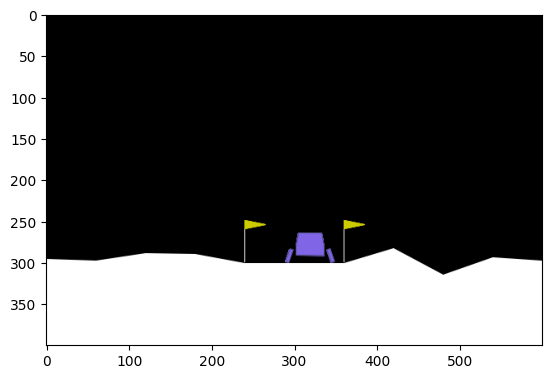

In [17]:
save_demo(model, 10, 'trail')

# Reward Shaping

## Training process

In [18]:
fix(env, 666)
r_s_agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
training_result_rs = TrainOnce(c2, eps_clip, r_s_agent, reward_mode="center")

Training with c2: -0.006, eps_clip: 0.22
Update Count: 9, average rewards: -156.65724714022892, episode: 100, success rate: 0.0
Update Count: 18, average rewards: -131.1313370692967, episode: 200, success rate: 0.0
Update Count: 36, average rewards: -74.6727918777089, episode: 300, success rate: 0.0
Update Count: 96, average rewards: 55.67088948214297, episode: 400, success rate: 0.0033333333333333335
Update Count: 130, average rewards: 191.78699058882728, episode: 500, success rate: 0.25666666666666665
Target score reached in 515 episodes!


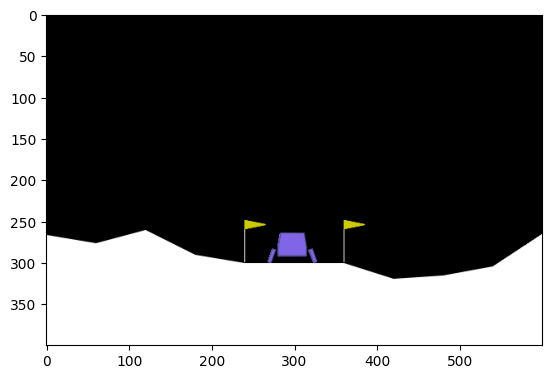

In [20]:
save_demo(r_s_agent, 5, 'reward shaping')

## Compare to normal process

In [21]:
fix(env, 666)
normal_agent = PPOAgent(state_dim ,action_dim,n_latent_var,update_timestep, lr,betas,gamma,K_epochs,eps_clip,c1,c2)
training_result_normal = TrainOnce(c2, eps_clip, normal_agent, reward_mode="none")

Training with c2: -0.006, eps_clip: 0.22
Update Count: 8, average rewards: -162.10956767229192, episode: 100, success rate: 0.0
Update Count: 20, average rewards: -90.42064367571102, episode: 200, success rate: 0.0
Update Count: 45, average rewards: 2.854553050484761, episode: 300, success rate: 0.01
Update Count: 76, average rewards: 102.82671025111897, episode: 400, success rate: 0.17666666666666667
Update Count: 101, average rewards: 90.45713876212217, episode: 500, success rate: 0.33666666666666667
Update Count: 121, average rewards: 138.3374849882902, episode: 600, success rate: 0.49666666666666665
Update Count: 142, average rewards: 122.01974769916924, episode: 700, success rate: 0.49333333333333335
Update Count: 162, average rewards: 134.73161740727858, episode: 800, success rate: 0.5
Update Count: 187, average rewards: 185.84101327353247, episode: 900, success rate: 0.56
Update Count: 207, average rewards: 127.4906261286481, episode: 1000, success rate: 0.5433333333333333
Targe

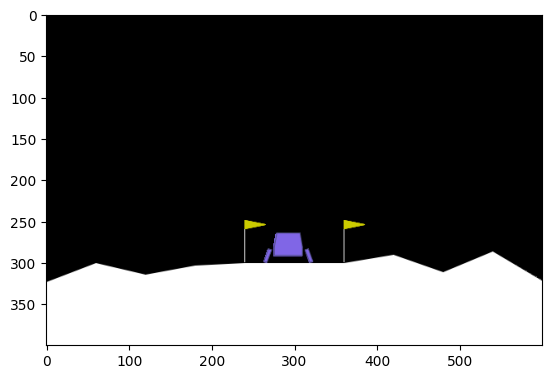

In [22]:
save_demo(normal_agent, 5, 'compare')